# Preprocess Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("resources/stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
print(df['smoking_status'].unique())
print(df['gender'].unique())
print(df['work_type'].unique())
print(df['Residence_type'].unique())

['formerly smoked' 'never smoked' 'smokes' 'Unknown']
['Male' 'Female' 'Other']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']


In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

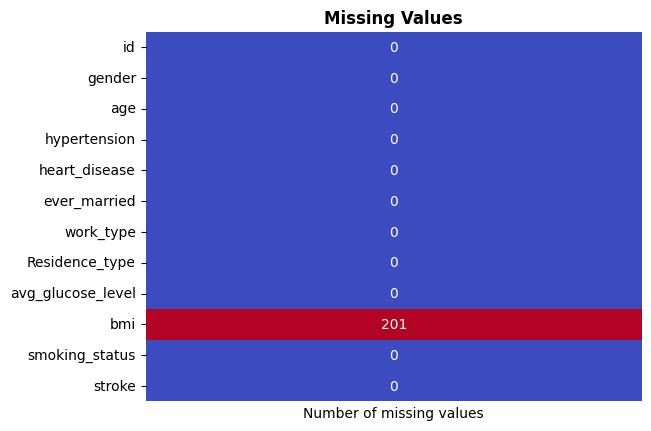

In [6]:
plt.title('Missing Values', fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='coolwarm', cbar=False)
ax.set_xlabel('Number of missing values')
ax.set_xticks([])
plt.show()

## Fill gaps

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [8]:
DTR_bmi_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('DTR', DecisionTreeRegressor(random_state=42))])
X_bmi = df[['age','gender','bmi']].copy()
X_bmi.gender = X_bmi.gender.replace({'Male': 0,'Female': 1,'Other': -1}).astype(np.uint8)

X_with_missing_bmis = X_bmi[X_bmi.bmi.isna()]
X_bmi = X_bmi[~X_bmi.bmi.isna()]
y_bmi = X_bmi.pop('bmi')
DTR_bmi_pipe.fit(X_bmi, y_bmi)
predicted_bmis = pd.Series(DTR_bmi_pipe.predict(X_with_missing_bmis[['age','gender']]), index=X_with_missing_bmis.index)
df.loc[X_with_missing_bmis.index, 'bmi'] = predicted_bmis

In [9]:
print('Overall number of missing values: ', sum(df.isnull().sum()))

Overall number of missing values:  0


# Model preparation

## Encode categorical values

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
df['ever_married'] = LabelEncoder().fit_transform(df['ever_married'])
df['Residence_type'] = LabelEncoder().fit_transform(df['Residence_type'])
df['gender'] = LabelEncoder().fit_transform(df['gender'])
df['work_type'] = LabelEncoder().fit_transform(df['work_type'])
df['smoking_status'] = LabelEncoder().fit_transform(df['smoking_status'])

In [12]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,29.879487,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [13]:
corr = df.drop(columns=['id']).corr()

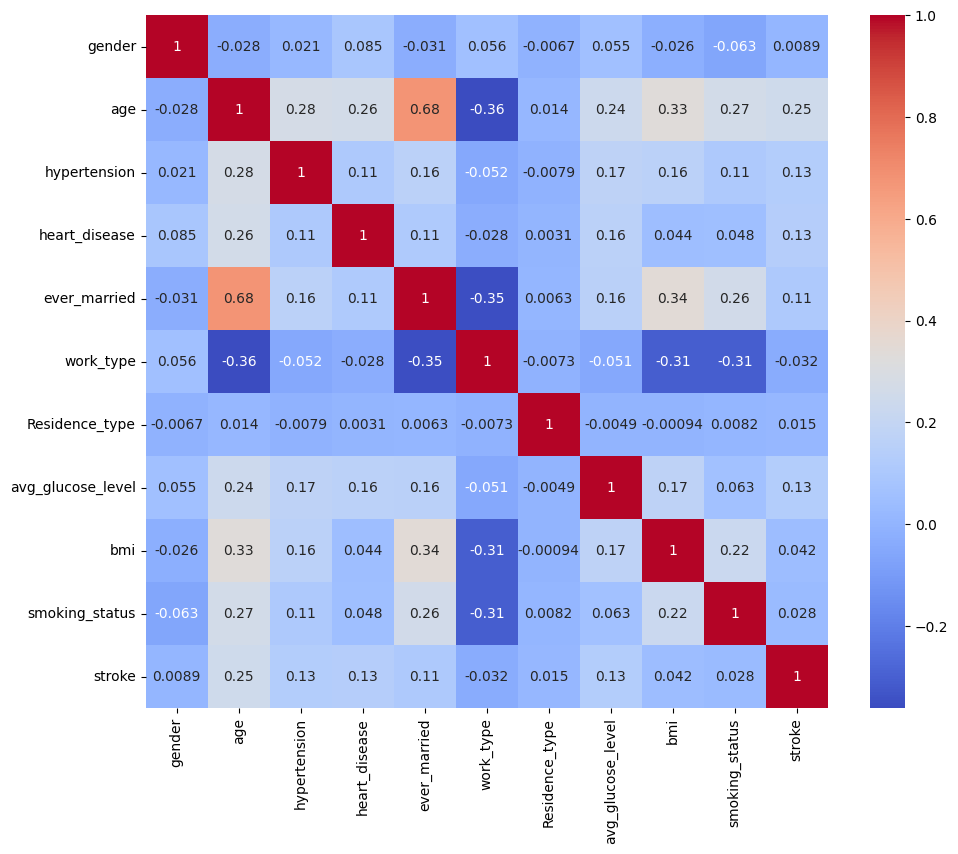

In [14]:
plt.figure(figsize=(11, 9))
ax = sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.xticks(rotation=90)
plt.show()

## Balance dataset

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
y = df['stroke']
X = df.drop(columns=['stroke', 'id', "ever_married"])

In [17]:
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9722 entries, 0 to 9721
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             9722 non-null   int32  
 1   age                9722 non-null   float64
 2   hypertension       9722 non-null   int64  
 3   heart_disease      9722 non-null   int64  
 4   work_type          9722 non-null   int32  
 5   Residence_type     9722 non-null   int32  
 6   avg_glucose_level  9722 non-null   float64
 7   bmi                9722 non-null   float64
 8   smoking_status     9722 non-null   int32  
dtypes: float64(3), int32(4), int64(2)
memory usage: 531.8 KB


<Axes: xlabel='stroke', ylabel='count'>

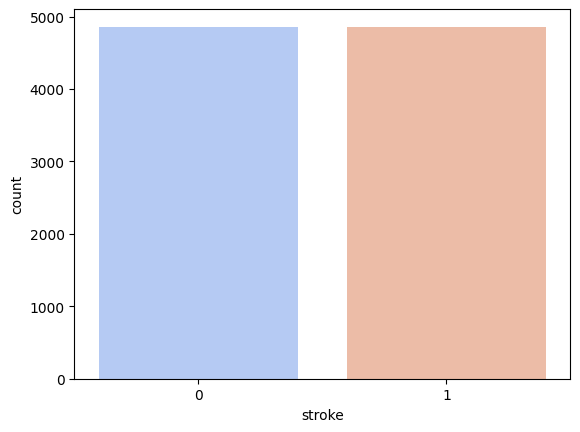

In [19]:
sns.countplot(x=y, palette='coolwarm')

## Split dataset into train and test sets

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

# Building models

In [22]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [23]:
def test_models(X_train, y_train, X_test, y_test):
    models = [['KNearest Neighbor Classifier',KNeighborsClassifier(leaf_size=1, n_neighbors=14, p=2)],
              ['Decision Tree Classifier ',DecisionTreeClassifier()],
              ['Random Forest Classifier ',RandomForestClassifier()],
              ['Ada Boost Classifier',AdaBoostClassifier()],
              ['SVM Classifier',SVC(probability=True)],
              ['XG Boost Classifier',XGBClassifier(learning_rate=0.1, max_depth=9, n_estimators=100)],
              ['Cat Boost Classifier',CatBoostClassifier(logging_level='Silent')]]

    model_scores = []
    for name, model in models:

        curr_model = model
        curr_model.fit(X_train, y_train)
        curr_model_pred = curr_model.predict(X_test)
        cm_model = confusion_matrix(y_test, curr_model_pred)
        model_scores.append((name, accuracy_score(y_test, curr_model_pred), f1_score(y_test, curr_model_pred)))

        plt.title(name)
        sns.heatmap(confusion_matrix(y_test, curr_model_pred), annot=True, fmt='g', cmap='coolwarm', cbar=False, 
            yticklabels=['Actual non-stroke', 'Actual Stroke'], xticklabels=['Predicted non-stroke', 'Predicted stroke'])
        
        plt.show()
        
        curr_model_pred_p = curr_model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, curr_model_pred_p)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC ({name}) = ' + str(round(roc_auc, 2)))
        plt.legend(loc='lower right')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title(f'ROC curve plot ({name})')
        plt.show()
        
        cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
        print("Cross Validation Score (f1): ", '{0:.2%}'.format(cross_val_score(curr_model, X_train, y_train, cv = cv, scoring = 'f1').mean()))
        
        print(classification_report(y_test, curr_model_pred))
        
    return model_scores

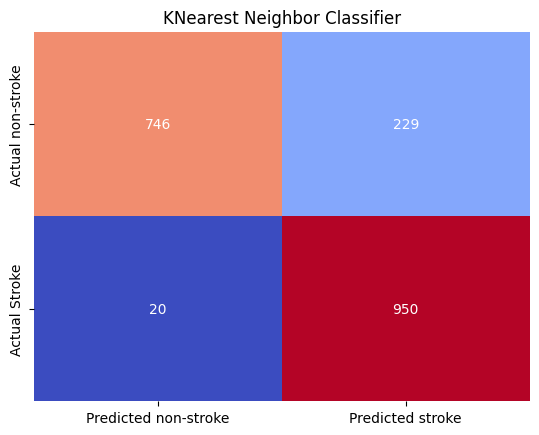

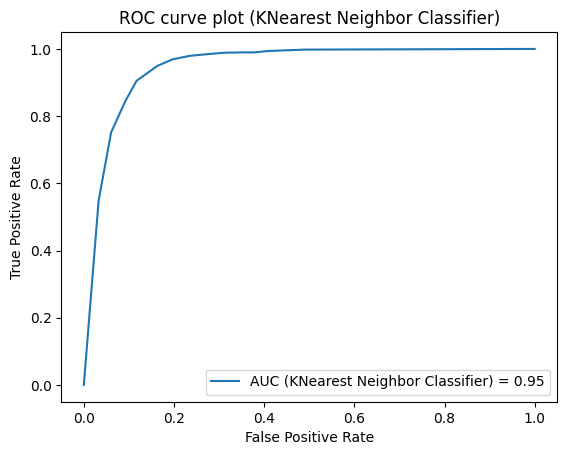

Cross Validation Score (f1):  87.95%
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       975
           1       0.81      0.98      0.88       970

    accuracy                           0.87      1945
   macro avg       0.89      0.87      0.87      1945
weighted avg       0.89      0.87      0.87      1945



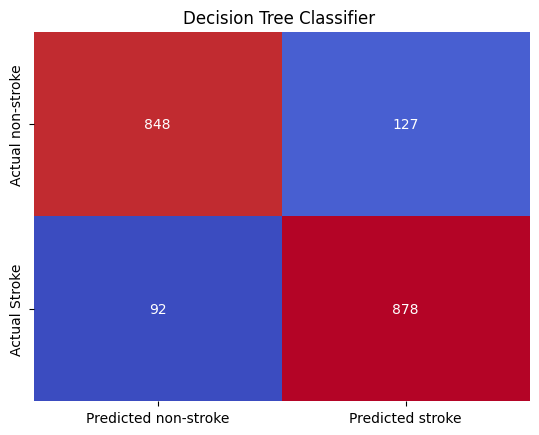

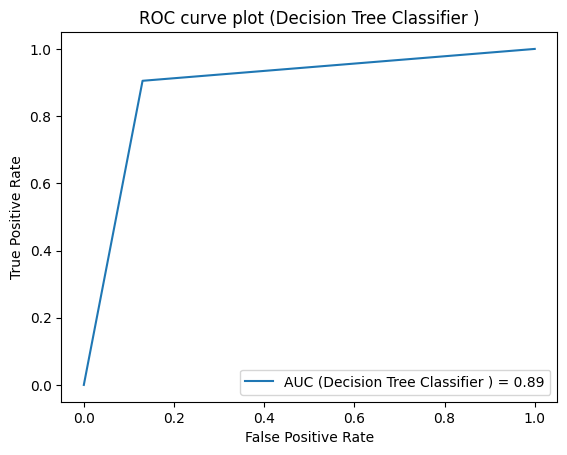

Cross Validation Score (f1):  90.45%
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       975
           1       0.87      0.91      0.89       970

    accuracy                           0.89      1945
   macro avg       0.89      0.89      0.89      1945
weighted avg       0.89      0.89      0.89      1945



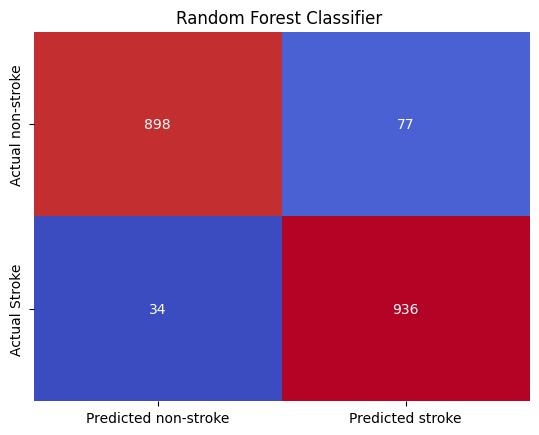

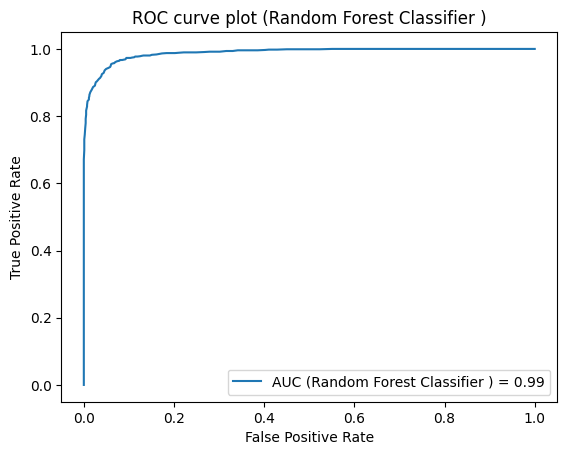

Cross Validation Score (f1):  93.62%
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       975
           1       0.92      0.96      0.94       970

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945



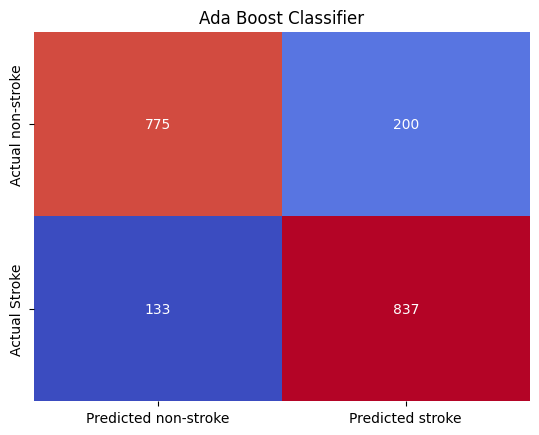

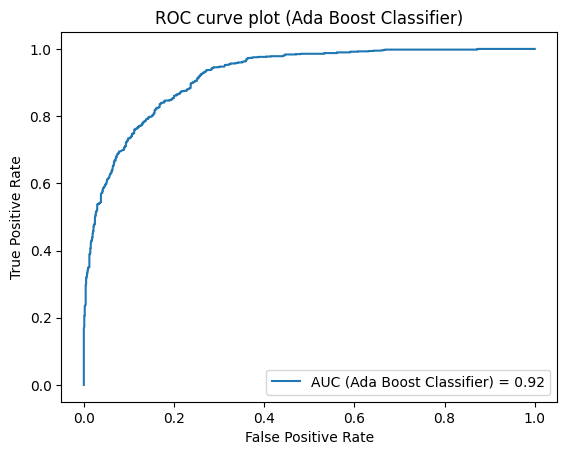

Cross Validation Score (f1):  83.90%
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       975
           1       0.81      0.86      0.83       970

    accuracy                           0.83      1945
   macro avg       0.83      0.83      0.83      1945
weighted avg       0.83      0.83      0.83      1945



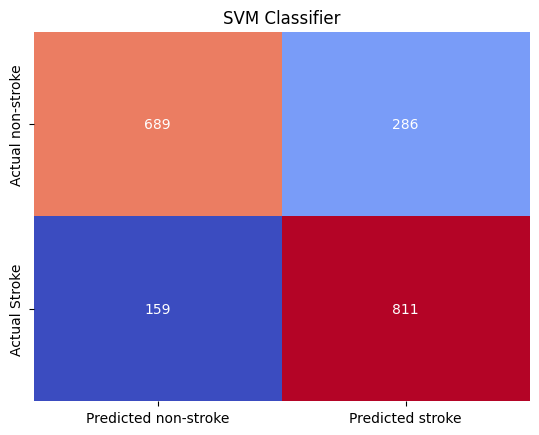

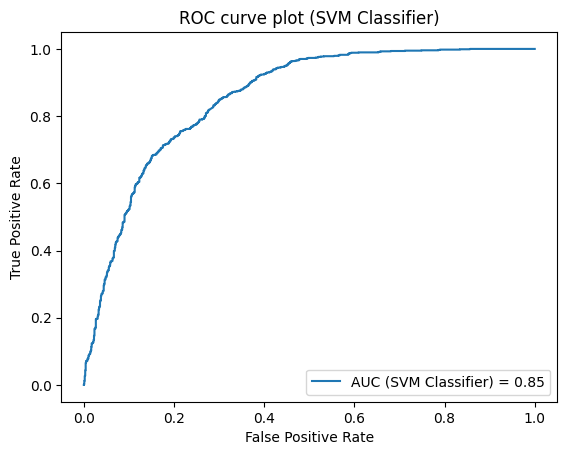

Cross Validation Score (f1):  79.56%
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       975
           1       0.74      0.84      0.78       970

    accuracy                           0.77      1945
   macro avg       0.78      0.77      0.77      1945
weighted avg       0.78      0.77      0.77      1945



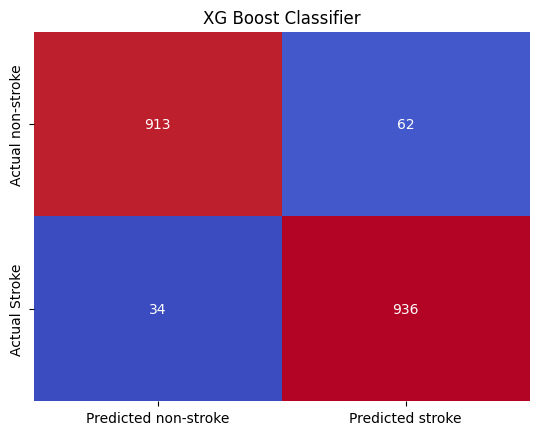

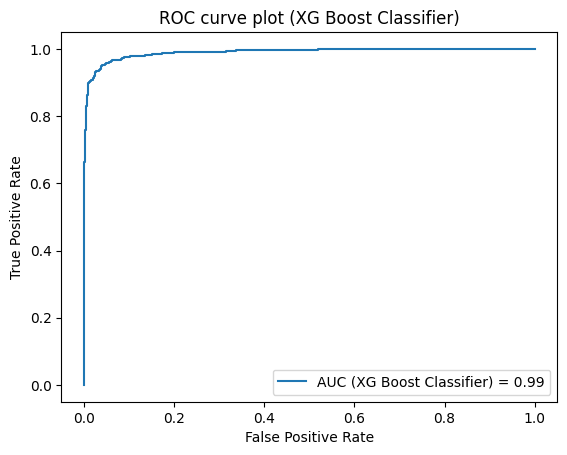

Cross Validation Score (f1):  94.27%
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       975
           1       0.94      0.96      0.95       970

    accuracy                           0.95      1945
   macro avg       0.95      0.95      0.95      1945
weighted avg       0.95      0.95      0.95      1945



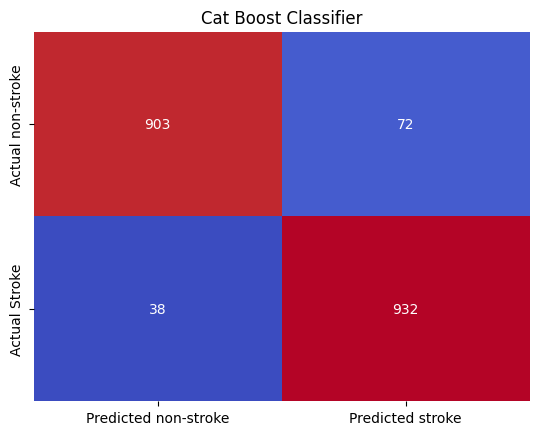

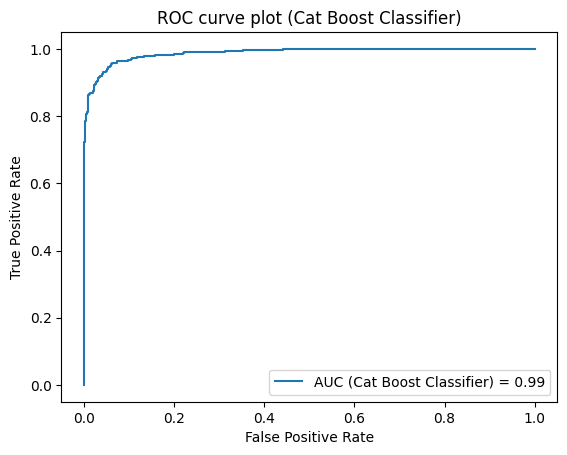

Cross Validation Score (f1):  93.64%
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       975
           1       0.93      0.96      0.94       970

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945



In [24]:
model_scores = test_models(X_train, y_train, X_test, y_test)

# Tuning models

In [25]:
from sklearn.model_selection import GridSearchCV